In [1]:
from textblob import TextBlob
import spacy
from spacy.lang.en import English
from spacy import displacy
import en_core_web_sm
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect 
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
print("Libraries Imported")

Libraries Imported


In [69]:
consumerKey = 
consumerSecret = 
accessToken = 
accessTokenSecret = 
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit=True)

print("API Authentication")

API Authentication


In [3]:
nlp = English()

In [4]:
def tweet_cleaning(x): #remove link
    remove_RT = lambda x: re.compile('\#').sub('', re.compile('RT @').sub('@', x, count=1).strip())
    x = remove_RT(x)
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            x = x.replace(separator,' ')
    words = []
    for word in x.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [5]:
def tweet_sentiment_analysis(x):
    the_tweet = TextBlob(x)
    pol = the_tweet.sentiment.polarity
    sub = the_tweet.sentiment.subjectivity
    score = SentimentIntensityAnalyzer().polarity_scores(x)
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']
    comp = score['compound']
    sentiment = ''
    if pos > neg :
        sentiment = 'Positive'
    elif pos < neg :
        sentiment = 'Negative'
    else :
        sentiment = 'Neutral'
    return int(pol*100), int(sub*100), score, int(neg*100),int(pos*100) , int(neu*100), int(comp*100),sentiment

In [6]:
def tweet_tokenizer(x) :
    text = x
    my_doc = nlp(text)
    tokens = []
    for token in my_doc :
        tokens.append(token.text)
    return tokens

In [7]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [56]:
def get_tweets(keyword, noOfTweet) :
    tweets = tweepy.Cursor(api.search,q=keyword, lang="en").items(noOfTweet)
    tweet_list = []
    cleaned_tweets_list = []
    tweet_size = []
    for tweet in tweets :
        tweet_list.append(tweet.text)
        cleaned_tweet = tweet_cleaning(tweet.text)
        tweet_size.append(len(cleaned_tweet))
        cleaned_tweets_list.append(cleaned_tweet)
    return tweet_list,cleaned_tweets_list, tweet_size

In [67]:
def get_tweets_2(keyword, noOfTweet) :
    tweets = tweepy.Cursor(api.search,q=keyword, lang="en").pages(noOfTweet/200)
    tweet_list = []
    cleaned_tweets_list = []
    tweet_size = []
    for tweet in tweets :
        tweet_list.append(tweet.text)
        cleaned_tweet = tweet_cleaning(tweet.text)
        tweet_size.append(len(cleaned_tweet))
        cleaned_tweets_list.append(cleaned_tweet)
    return tweet_list,cleaned_tweets_list, tweet_size

In [9]:
def get_sentiment_percentage(cleaned_tweets_list, positive_tweet_list, negative_tweet_list, neutral_tweet_list) :
    positive_percentage = percentage(len(positive_tweet_list), len(cleaned_tweets_list))
    negative_percentage = percentage(len(negative_tweet_list), len(cleaned_tweets_list))
    neutral_percentage = percentage(len(neutral_tweet_list), len(cleaned_tweets_list))
    return positive_percentage, negative_percentage, neutral_percentage


In [10]:
def final_data_generation(cleaned_tweets_list, tweet_size) :
    counter = 0 
    polarity_list = []
    subjectivity_list = []
    positive_tweet_list = []
    negative_tweet_list = []
    neutral_tweet_list = []
    score_tweet_list = []
    positivty = []
    negativity = []
    neutralness = []
    compoundness = []
    df_tweetdata = pd.DataFrame(columns = ['Tweet','WordCount','Polarity','Subjectivity','Sentiment','Positivity','Negativity','Neutralness','Compoundness'])
    
    for x in cleaned_tweets_list :
        tweet_pol, tweet_sub, score, neg, pos, neu, comp, sentiment = tweet_sentiment_analysis(x)
        
        positivty.append(pos)
        negativity.append(neg)
        neutralness.append(neu)
        compoundness.append(comp)
        polarity_list.append(tweet_pol)
        subjectivity_list.append(tweet_sub)
        score_tweet_list.append(sentiment)
        
        if pos > neg :
            positive_tweet_list.append(x)        
        elif neg > pos :
            negative_tweet_list.append(x)
        elif pos == neg :
            neutral_tweet_list.append(x)
    
    df_tweetdata['Tweet'] = cleaned_tweets_list
    df_tweetdata['WordCount'] = tweet_size
    df_tweetdata['Polarity'] = polarity_list
    df_tweetdata['Subjectivity'] = subjectivity_list
    df_tweetdata['Sentiment'] = score_tweet_list
    df_tweetdata['Positivity'] = positivty
    df_tweetdata['Negativity'] = negativity
    df_tweetdata['Neutralness'] = neutralness
    df_tweetdata['Compoundness'] = compoundness
    
    positive_percentage, negative_percentage, neutral_percentage = get_sentiment_percentage(cleaned_tweets_list, positive_tweet_list, negative_tweet_list, neutral_tweet_list)
    
    return polarity_list,subjectivity_list,positive_percentage,negative_percentage,neutral_percentage,score_tweet_list,positivty,negativity,neutralness,compoundness,df_tweetdata

In [57]:
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
total_tweets = []
total_cleaned_tweets = []
total_tweet_size = []
while len(total_cleaned_tweets) < noOfTweet :
    tweet_list, cleaned_tweets_list, tweet_size = get_tweets(keyword, noOfTweet)
    total_cleaned_tweets = total_cleaned_tweets + cleaned_tweets_list
    total_tweets = total_tweets + tweet_list
    total_tweet_size = total_tweet_size + tweet_size

polarity_list,subjectivity_list,positive_percentage, negative_percentage, neutral_percentage,score_tweet_list,positivty,negativity,neutralness,compoundness,df_tweetdata = final_data_generation(total_cleaned_tweets, total_tweet_size)
print(len(total_cleaned_tweets))

Please enter keyword or hashtag to search:  pixel6
Please enter how many tweets to analyze:  1000


1476


In [68]:
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
tweet_list, cleaned_tweets_list, tweet_size = get_tweets_2(keyword, noOfTweet)
print(len(cleaned_tweets_list))

Please enter keyword or hashtag to search:  pixel6
Please enter how many tweets to analyze:  1000


AttributeError: 'SearchResults' object has no attribute 'text'

In [58]:
print("Percentage of Positive:\t",positive_percentage)
print("Percentage of Negative:\t",negative_percentage)
print("Percentage of Neutral:\t",neutral_percentage)

Percentage of Positive:	 41.05691056910569
Percentage of Negative:	 13.414634146341463
Percentage of Neutral:	 45.52845528455285


In [25]:
#The compound score is the sum of positive, negative & neutral scores which is then normalized 
#between -1(most extreme negative) and +1 (most extreme positive). 
#The more Compound score closer to +1, the higher the positivity of the text.

In [59]:
df_tweetdata.head(20)

,Tweet,WordCount,Polarity,Subjectivity,Sentiment,Positivity,Negativity,Neutralness,Compoundness
0,🤎new pixelart🤎 draw drawing drawings paint pai...,106,0,0,Neutral,0,0,100,0
1,🤎new pixelart🤎 draw drawing drawings paint pai...,117,0,0,Neutral,0,0,100,0
2,Just me or is crushing it on the new phone fro...,121,7,68,Negative,0,9,90,-36
3,Google Pixel 6 will be without charger 😱 Read ...,127,35,55,Neutral,0,0,100,0
4,Same in India but you are luck that you will g...,59,0,12,Positive,25,0,75,61
5,nerdy Google Pixel 6 rumors Release date in ho...,120,50,50,Negative,0,5,94,-5
6,Google Pixel 6 rumors Release date in house ch...,130,50,50,Neutral,0,0,100,0
7,Google will not include a charger with the Pix...,99,0,10,Neutral,0,0,100,0
8,Master18 Google Pixel 6 and 6 Pro may support ...,125,10,80,Positive,13,9,77,20
9,No charger in Pixel 6 😮😭 Pixel6 GooglePixel6,44,0,0,Negative,0,26,73,-29


In [63]:
df_tweetdata.shape

(371, 10)

In [64]:
df_tweetdata.drop_duplicates(inplace=True)
df_tweetdata.reset_index(inplace=True)

In [65]:
df_tweetdata.shape

(371, 11)

In [30]:
#df_tweetdata.to_csv('Tweet_Hype_Data_2.csv')

In [66]:
token_list = []
index_list = []
counter = 0
for x in cleaned_tweets_list:
    tokens = tweet_tokenizer(x)
    token_list.append(tokens)
    counter += len(tokens)
    index_list.append(counter)

In [32]:
#printed out token_list and index_list
print("cleaned_tweets_list",len(cleaned_tweets_list))
print("token_list",len(token_list))

cleaned_tweets_list 492
token_list 492


In [33]:
tweet_tokens = []
tweet_POS = []
for x in cleaned_tweets_list :
    tokens_POS = TextBlob(x)
    res = [[ i for i, j in tokens_POS.tags ],[ j for i, j in tokens_POS.tags ]]

In [34]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df_tweetdata.Sentiment = enc.fit_transform(df_tweetdata.Sentiment)
# df_tweetdata.Polarity = enc.fit_transform(df_tweetdata.Polarity)
# df_tweetdata.Subjectivity = enc.fit_transform(df_tweetdata.Subjectivity)
# df_tweetdata.Positivity = enc.fit_transform(df_tweetdata.Positivity)
# df_tweetdata.Negativity = enc.fit_transform(df_tweetdata.Negativity)
# df_tweetdata.Neutralness = enc.fit_transform(df_tweetdata.Neutralness)
# df_tweetdata.Compoundness = enc.fit_transform(df_tweetdata.Compoundness)

In [35]:
df_tweetdata.head(10)

,index,Tweet,WordCount,Polarity,Subjectivity,Sentiment,Positivity,Negativity,Neutralness,Compoundness
0,0,🤎new pixelart🤎 draw drawing drawings paint pai...,106,0,0,1,0,0,100,0
1,1,🤎new pixelart🤎 draw drawing drawings paint pai...,117,0,0,1,0,0,100,0
2,2,Just me or is crushing it on the new phone fro...,121,7,68,0,0,9,90,-36
3,3,Google Pixel 6 will be without charger 😱 Read ...,127,35,55,1,0,0,100,0
4,4,Same in India but you are luck that you will g...,59,0,12,2,25,0,75,61
5,5,nerdy Google Pixel 6 rumors Release date in ho...,120,50,50,0,0,5,94,-5
6,6,Google Pixel 6 rumors Release date in house ch...,130,50,50,1,0,0,100,0
7,7,Google will not include a charger with the Pix...,99,0,10,1,0,0,100,0
8,8,Master18 Google Pixel 6 and 6 Pro may support ...,125,10,80,2,13,9,77,20
9,9,No charger in Pixel 6 😮😭 Pixel6 GooglePixel6,44,0,0,0,0,26,73,-29


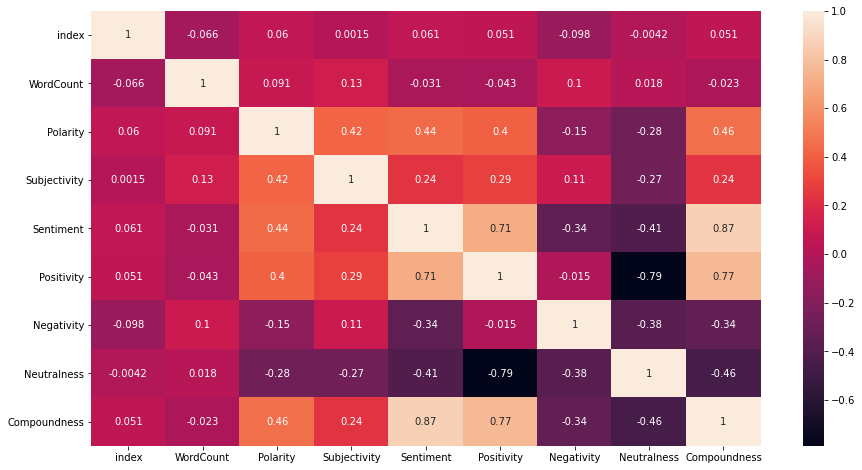

In [36]:
import seaborn as sns
c = df_tweetdata.corr(method = 'kendall')
plt.figure(figsize=(15,8))
sns.heatmap(c, annot=True)
plt.show()

In [37]:
feature_cols = ['Subjectivity','Sentiment','Positivity','Negativity','Compoundness']
X = df_tweetdata[feature_cols] # Features
y = df_tweetdata.Polarity # Target variable

In [38]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [39]:
logreg = LogisticRegression()

In [43]:
def get_best_randomstate(X,y):
    ts_score=[]
    for j in range(1000):
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=j)
        logreg.fit(X_train,y_train)
        y_pred=logreg.predict(X_test)
        ts_score.append(metrics.accuracy_score(y_test, y_pred))

    J= ts_score.index(np.max(ts_score))
    return J

In [44]:
J = get_best_randomstate(X,y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=J)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6533333333333333


In [45]:
print(J)

695


In [46]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None))
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

Accuracy: 0.6533333333333333
Precision: [1.         0.         0.         0.84313725 0.         1.
 0.         0.16666667 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333333
 0.         0.         0.         0.33333333]
Recall: [1.         0.         0.         0.97727273 0.         0.5
 0.         0.25       0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.5
 0.         0.         0.         1.        ]
